<img src="starbucks.png" style="height: 250px">

# Starbucks Capstone Challenge

### Notebook Content
- Part 1: Introduction
    - [Project Overview](#Overview)
	- [Problem Statement](#Problem-statement)
    - [Datasets](#Datasets)
- Part 2: Explanatory Data Analysis
	- [Load Packages](#Load-Packages)
	- [Load Datasets](#Load-data)
	- [Perform Data Preprocessing](#Perform-data-analysis)
- Part 3: Data Modeling
- Part 4: API_Packaging 

---

# 1. Introduction

<a id="Overview"></a>
## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 


<a id="#problem-statement"></a>
## Problem Statement
The goal of this project is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

<a id="#Datasets"></a>
## Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

---

# 2. Explanatory Data Analysis

<a id="#Load-Packages"></a>
## Load Packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
print('done')

done


<a id="#Load-"></a>
## Load Datasets

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)


(10, 6)
(17000, 5)
(306534, 4)


<a id="#Perform-data-analysis"></a>
## Perform Data Preprocessing

### Explore Portfolio Dataset

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
# Count of each data type
portfolio.dtypes.value_counts()

int64     3
object    3
dtype: int64

In [6]:
# Handy list of all the string/text columns in the dataset
list(portfolio.select_dtypes(include=object))

['channels', 'offer_type', 'id']

In [7]:
convert_dict = {'id': str,
                'offer_type': str
               }

In [8]:
portfolio = portfolio.astype(convert_dict)

In [9]:
portfolio.describe().T.style

,count,mean,std,min,25%,50%,75%,max
reward,10.000000,4.200000,3.583915,0.000000,2.000000,4.000000,5.000000,10.000000
difficulty,10.000000,7.700000,5.831905,0.000000,5.000000,8.500000,10.000000,20.000000
duration,10.000000,6.500000,2.321398,3.000000,5.000000,7.000000,7.000000,10.000000


In [10]:
portfolio.dtypes.value_counts()

int64     3
object    3
dtype: int64

In [11]:
# Number of unique values in each column
print(portfolio[['difficulty', 'duration', 'id', 'offer_type', 'reward']].nunique())

difficulty     5
duration       5
id            10
offer_type     3
reward         5
dtype: int64


In [12]:
# Change the unit of 'duration' column from days to hours
portfolio['duration'] = portfolio['duration']*24

In [13]:
portfolio.rename({'id': 'offer_id','duration':'duration_h'}, axis=1, inplace= True)

In [14]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration_h', 'offer_type',
       'offer_id'],
      dtype='object')

In [15]:
# Apply one hot encoding to channels column
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [16]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [17]:
# Replace categorical variable to numeric in offer_type 
portfolio['offer_type'].replace(['bogo', 'informational','discount'],
                        [0, 1,2], inplace=True)

In [18]:
# Drop channels column
portfolio.drop(['channels'], axis=1, inplace=True)

In [19]:
# Checking for missing values
portfolio.isnull().sum()

reward        0
difficulty    0
duration_h    0
offer_type    0
offer_id      0
web           0
email         0
mobile        0
social        0
dtype: int64

In [20]:
# Checking for duplicates
portfolio.duplicated().sum()

0

In [21]:
# Cleaned Portfolio Dataset
portfolio.head()

,reward,difficulty,duration_h,offer_type,offer_id,web,email,mobile,social
0,10,10,168,0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,1,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


### Explore Profile Dataset

In [22]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [24]:
profile.dtypes.value_counts()

object     2
int64      2
float64    1
dtype: int64

In [25]:
profile.describe().T.style

,count,mean,std,min,25%,50%,75%,max
age,17000.000000,62.531412,26.738580,18.000000,45.000000,58.000000,73.000000,118.000000
became_member_on,17000.000000,20167034.234118,11677.499961,20130729.000000,20160526.000000,20170802.000000,20171230.000000,20180726.000000
income,14825.000000,65404.991568,21598.299410,30000.000000,49000.000000,64000.000000,80000.000000,120000.000000


In [26]:
# check 118 age's records 
profile[profile['age']==118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


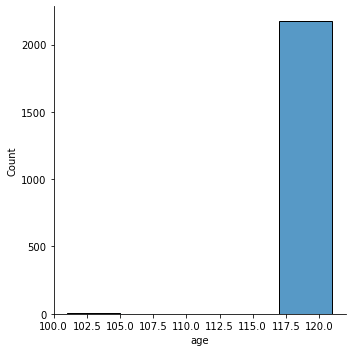

In [27]:
sns.displot(profile, x=profile[profile["age"]>100]['age'], binwidth=4)

In [28]:
profile.where(profile['age']==118).count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

`All the missing values are associated with 118 age's records, for that I will drop each record with 118 age value`

In [29]:
# Drop all rows with 118 age  
profile.drop(profile[profile['age'] == 118].index, inplace = True)

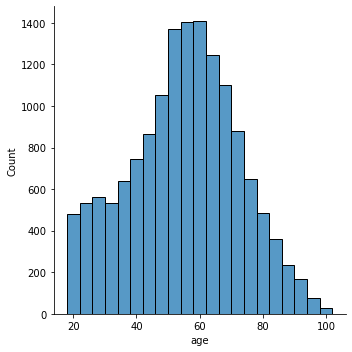

In [30]:
sns.displot(profile, x=profile["age"], binwidth=4)

In [31]:
# Rename id column to customer_id
profile.rename({'id': 'customer_id'}, axis=1, inplace= True)

In [32]:
# Change became_member_on type to the right one
profile['became_member_on'] = profile['became_member_on'].astype(str).astype('datetime64[ns]')

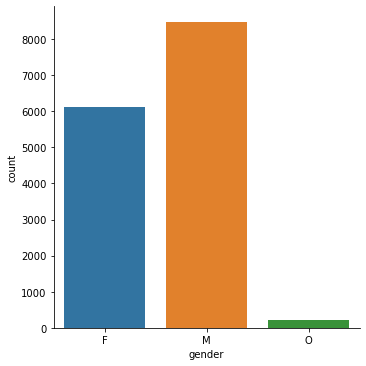

In [33]:
sns.catplot(x='gender', kind="count", data=profile)

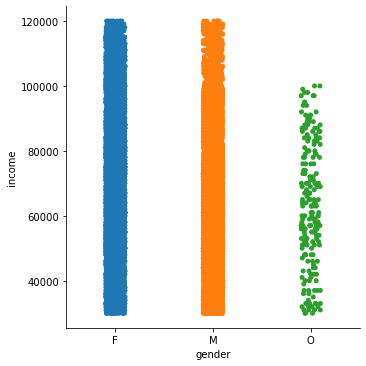

In [34]:
sns.catplot(x='gender', y='income',data=profile)

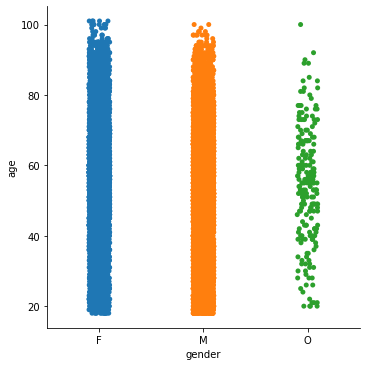

In [35]:
sns.catplot(x="gender", y="age", data=profile)

In [36]:
# Cleaned Profile Dataset
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


### Explore Transcript Dataset

In [37]:
transcript.head(60)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [38]:
transcript.rename({'person': 'customer_id'}, axis=1, inplace= True)

In [39]:
# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customer_id'].isin(profile['customer_id'])]

In [40]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [41]:
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [42]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  272762 non-null  object 
 1   event        272762 non-null  object 
 2   value        272762 non-null  object 
 3   time         272762 non-null  int64  
 4   offer id     116361 non-null  object 
 5   amount       123957 non-null  float64
 6   offer_id     32444 non-null   object 
 7   reward       32444 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 18.7+ MB


In [43]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [44]:
# drop value column
transcript.drop('value', axis=1, inplace=True)

In [45]:
# drop amount and reward columns since they have a huage number of missing valuse
transcript.drop('amount', axis=1, inplace=True)
transcript.drop('reward', axis=1, inplace=True)

In [46]:
# Drop transaction rows
transcript.drop(transcript[transcript['event']== 'transaction'].index,axis=0,inplace = True)

In [47]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [48]:
transcript.rename({'time':'time_h'}, axis=1, inplace=True)

In [49]:
transcript.head()

,customer_id,event,time_h,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [50]:
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [51]:
portfolio.head()

,reward,difficulty,duration_h,offer_type,offer_id,web,email,mobile,social
0,10,10,168,0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,1,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [52]:
master_df = transcript.merge(portfolio,how='left',on='offer_id')

In [53]:
master_df = master_df.merge(profile,how='left', on ='customer_id')

In [54]:
master_df.head()

,customer_id,event,time_h,offer_id,reward,difficulty,duration_h,offer_type,web,email,mobile,social,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,0,1,1,1,0,F,75,2017-05-09,100000.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,2,10,168,2,1,1,1,0,M,68,2018-04-26,70000.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,0,1,1,1,1,M,65,2018-02-09,53000.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0,0,96,1,1,1,1,0,M,58,2017-11-11,51000.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,240,2,1,1,0,0,F,61,2017-09-11,57000.0


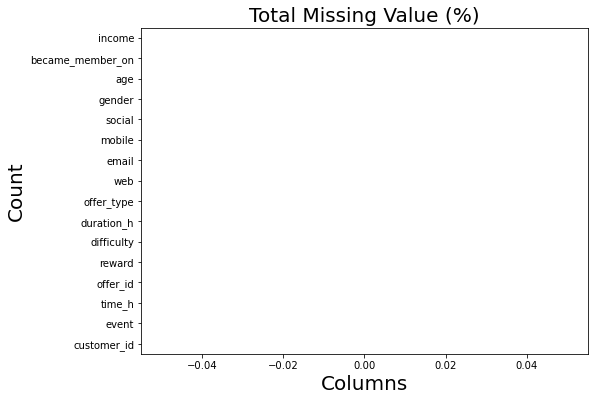

In [55]:
total = master_df.isnull().sum().sort_values(ascending=False)
percent = (master_df.isnull().sum()/master_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#histogram
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.sort_values().plot(kind="barh", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20);

In [60]:
master_df['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [63]:
# Replace categorical variable to numeric in gender 

master_df['gender'].replace(['O', 'M','F'],
                        [0, 1,2], inplace=True)

In [64]:
for col in master_df[['event']]:
    print(col, "\n", master_df[col].value_counts(dropna=False), "\n")

event 
 offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64 



In [65]:
master_df.drop(master_df[master_df['event']=='offer received'].index, inplace=True,axis=0)

In [66]:
master_df['event'] = master_df['event'].apply(lambda x: 0 if 'offer viewed' in x else 1)

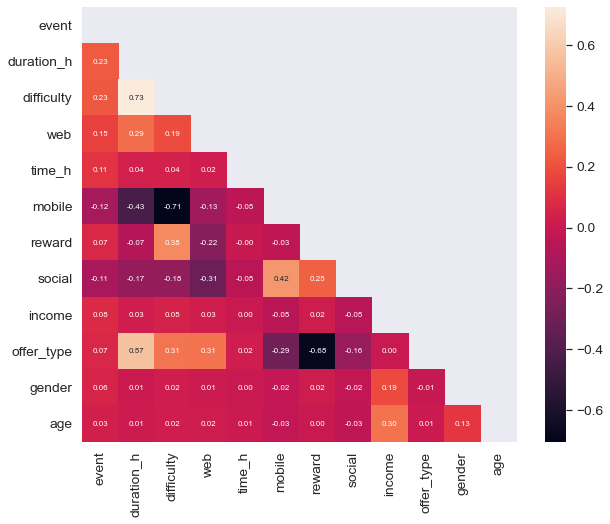

In [67]:
# Event correlation matrix
k = 17 #number of variables for heatmap
corrmat = abs(master_df.corr(method='spearman'))
# nlargest : Return this many descending sorted values
cols = corrmat.nlargest(k, 'event').index
cm = np.corrcoef(master_df[cols].values.T) 
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(10, 8))

# Hide upper symmetric metrics
mask = np.zeros_like(cm) 
mask[np.triu_indices_from(mask)] = True 
sns.set_style("white")
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 8}, yticklabels=cols.values, 
                 xticklabels=cols.values, mask = mask)
plt.show()

In [91]:
master_df[master_df['difficulty']==20].count()

customer_id         5601
event               5601
time_h              5601
offer_id            5601
reward              5601
difficulty          5601
duration_h          5601
offer_type          5601
web                 5601
email               5601
mobile              5601
social              5601
gender              5601
age                 5601
became_member_on    5601
income              5601
dtype: int64

# Part 3: Data Modeling

In [68]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 11023 to 148804
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       82304 non-null  object        
 1   event             82304 non-null  int64         
 2   time_h            82304 non-null  int64         
 3   offer_id          82304 non-null  object        
 4   reward            82304 non-null  int64         
 5   difficulty        82304 non-null  int64         
 6   duration_h        82304 non-null  int64         
 7   offer_type        82304 non-null  int64         
 8   web               82304 non-null  int64         
 9   email             82304 non-null  int64         
 10  mobile            82304 non-null  int64         
 11  social            82304 non-null  int64         
 12  gender            82304 non-null  int64         
 13  age               82304 non-null  int64         
 14  became_member_on 

In [69]:
master_df.columns

Index(['customer_id', 'event', 'time_h', 'offer_id', 'reward', 'difficulty',
       'duration_h', 'offer_type', 'web', 'email', 'mobile', 'social',
       'gender', 'age', 'became_member_on', 'income'],
      dtype='object')

Split data into features and target labels, considering ONLY those features that I believe are important for my model to predict accurately.

Those features are as follows:

    time_h
    reward
    difficulty
    duration_h
    offer_type
    gender_F
    gender_M
    gender_O
    age
    income

Our target is:

    'event' that will be either:
        1 : offer completed
        0 : offer viewed



In [92]:
X = master_df[['time_h','offer_type','difficulty','duration_h','gender','age','income']]
Y = master_df['event']

In [94]:
# Normalizing some numerical values 
scaler = MinMaxScaler()
features = ['time_h','duration_h', 'difficulty']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time_h,offer_type,duration_h,gender,age,income
11023,0.0,0,0.285714,1,65,53000.0
11024,0.0,1,0.000000,0,53,52000.0
11025,0.0,0,0.285714,2,69,57000.0
11026,0.0,0,0.571429,2,20,30000.0
11027,0.0,1,0.000000,1,39,51000.0


In [95]:
# Creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [96]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse)
print(rmse_score)

make_scorer(rmse)


In [97]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [104]:
#Decision Tree Model

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((dt.score(X_test, y_test)*100),2)}%')
print(f'Decision Tree RMSE on Training set: {round(rmse_cv_train(dt).mean(),2)}' )
print(f'Decision Tree RMSE on Testing set: {round(rmse_cv_test(dt).mean(),2)}' )

Accuracy of Decision Tree classifier on training set: 97.24%
Testing Accuracy: 59.37%
Decision Tree RMSE on Training set: 0.64
Decision Tree RMSE on Testing set: 0.63


In [99]:
#Support Vector Machine Model

svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((svm.score(X_test, y_test)*100),2)}%')
print(f'Decision Tree RMSE on Training set: {round(rmse_cv_train(svm).mean(),2)}' )
print(f'Decision Tree RMSE on Testing set: {round(rmse_cv_test(svm).mean(),2)}' )

Accuracy of SVM classifier on training set: 95.73%
Testing Accuracy: 59.04%
Decision Tree RMSE on Training set: 0.64
Decision Tree RMSE on Testing set: 0.63


In [100]:
#Naive Bayes Model

gnb = GaussianNB() 

gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((gnb.score(X_test, y_test)*100),2)}%')
print(f'Decision Tree RMSE on Training set: {round(rmse_cv_train(gnb).mean(),2)}' )
print(f'Decision Tree RMSE on Testing set: {round(rmse_cv_test(gnb).mean(),2)}' )

Accuracy of SVM classifier on training set: 62.45%
Testing Accuracy: 62.5%
Decision Tree RMSE on Training set: 0.61
Decision Tree RMSE on Testing set: 0.61


In [101]:
#Random Forest Model

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((rf.score(X_test, y_test)*100),2)}%')
print(f'Decision Tree RMSE on Training set: {round(rmse_cv_train(rf).mean(),2)}' )
print(f'Decision Tree RMSE on Testing set: {round(rmse_cv_test(rf).mean(),2)}' )

Accuracy of SVM classifier on training set: 82.08%
Testing Accuracy: -0.49%
Decision Tree RMSE on Training set: 0.49
Decision Tree RMSE on Testing set: 0.47


In [102]:
#K-Nearest Neighbors Model

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((knn.score(X_test, y_test)*100),2)}%')
print(f'Decision Tree RMSE on Training set: {round(rmse_cv_train(knn).mean(),2)}' )
print(f'Decision Tree RMSE on Testing set: {round(rmse_cv_test(knn).mean(),2)}' )

Accuracy of K-NN classifier on training set: 74.61%
Testing Accuracy: 61.78%
Decision Tree RMSE on Training set: 0.62
Decision Tree RMSE on Testing set: 0.63


In [103]:
#LogisticRegression Model 



logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((logreg.score(X_test, y_test)*100),2)}%')
print(f'Decision Tree RMSE on Training set: {round(rmse_cv_train(logreg).mean(),2)}' )
print(f'Decision Tree RMSE on Testing set: {round(rmse_cv_test(logreg).mean(),2)}' )

Accuracy of Logistic regression classifier on training set: 59.18%
Testing Accuracy: 59.08%
Decision Tree RMSE on Training set: 0.64
Decision Tree RMSE on Testing set: 0.64


# Part 4: API_Packaging 

This part is available in `train_save_model` and `model_API` files.

## Conclusion
Through this project , I tried to analyze the datasets provided by Starbucks and then build a model that can predict whether a customer would complete the offer or just view it?

First, I have explored each dataset, visualize it to get an overall understanding on the data. This also included analyzing different aspects of the datasets. Then, I moved to the Preprocessing Part. Preprocessing Data was the task that took most of the time and effort. The dataset is a bit tricky and the data included required me to use my wrangling/ engineering and preprocessing skills to get the final clean version of the three datasets. The next step was to create some latent features that can improve the performance of the model. These featured were actually derived from orginal existing column but with less range of values and simple values to include within the data set. Examples on that are the following:

    'age_group' feature derived from 'age' feature. I was ,then, replace the feature's categorical labels by a corresponding numerical label, as follows:
        1 : teenager
        2 : young-adult
        3 : adult
        4 : elderly

    'income_range' feature derived from 'income' feature. that includes the income-range to which the customer's income belongs. Then, I replaced the 'income_range' categorical labels by corresponding numerical labels, as follows:
        1 : average (30,000 - 60,000)
        2 : above-average (60,0001 - 90,000)
        3 : high (more than 90,000)

    'member_type' feature derived from 'became_member_on' feature. Of course, the features categorical labels has been replaced by corresponding numerical labels, as follows:
        1 : new (memebr since 1000 days or less)
        2 : regular (1001 - 1,600 days of membership)
        3 : loyal (more than 1,600 days of membership)

The quick analysis on the datasets allowed me to get the following insights:

    Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
    According to the available data, There are three ‘gender’ categories into which the customers falls in ( M, F and O). Keeping in our mind the above observation that there are 2175 missing values, Male Customers (8484 men) are more than Female Customers(6129 women) with 57% of customers are Males compared to 41% Females. However, there are 212 customers chose “O” as their gender.
    The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.
    Customers with High income (Above 90,000) are mostly female customers. Whereas, Average Income(30,000 - 60,000) customers are mostly males.
    Males and Females are pretty close when it comes to the time spent to complete an offer. Both males and females take about 17 days to da so.
    2017 was the best year for Starbucks in terms of the number of new members. Around %38 of all the customers on our dataset regiseterd as members on this specific year.
    Both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not interested to it.
    The mean time it takes a customer to complete an offer is less than 16 days (372 hours).
    Females completed around 75% of the offers they viewed, it is 16% more than males who just completed 58% of the offers they viewed. Feamles seems to be convinced by the promotion easier than males.

## Reflection

I really enjoyed working on this capstone project which allowed me to polish my skills in Data Preprocessing and Modeling. The most difficult part in my opinion was deciding on the problem statement. This is because a weak problem statement would surly cause the other work to be under appreciated and valued.

The Preprocessing Step was the longest and most challanging part to complete. The Dataset itself is inspiring. Honestly,Everything was amazing.
Improvement

I believe I got to a point where I had very good results when it comes to the prediction model. I understood the data provided by Starbucks very well.

As there is always space for improvment, I believe that the idea of improving the data coeelction or fixing issues related with the missing data or NaNs would be really helpful. In my opinion, I think that we can get great insights from this data set and great prediction models might be also built to solve problems statemetns associated with this data set . Examples for these model are the following :

    Building a model that can predict which kind of offers to be sent to whcihc customer?
    Building a model that can predict which customers would buy any way ( regardless if there is an offer or not)